In [10]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [11]:
# Loading the datasets
train_df = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/Final_Train.csv')
test_df = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/Final_test.csv')
validation_df = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/Final_Validation.csv')

In [12]:
# Function for preprocessing the datasets
def preprocess_data(df):
    df['local_time'] = pd.to_datetime(df['local_time'])
    for time_unit in ['Year', 'Month', 'Day', 'Hour']:
        df[time_unit] = getattr(df['local_time'].dt, time_unit.lower())
    return df.drop('local_time', axis=1)

In [13]:
def add_cyclical_features(df, col_name, max_val):
    if col_name in df.columns:
        df[col_name + '_sin'] = np.sin(2 * np.pi * df[col_name] / max_val)
        df[col_name + '_cos'] = np.cos(2 * np.pi * df[col_name] / max_val)
    return df

# Creating Cyclical features like 'Hour', 'Day', and 'Month'
for df in [train_df, validation_df, test_df]:
    df = add_cyclical_features(df, 'Hour', 23)
    df = add_cyclical_features(df, 'Day', 31) 
    df = add_cyclical_features(df, 'Month', 12)


In [14]:
def add_lagged_features(df, feature_cols, n_lags=3):
    for feature in feature_cols:
        for lag in range(1, n_lags + 1):
            df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
    return df.dropna().reset_index(drop=True)

# Preprocessing all the datasets
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)
validation_df = preprocess_data(validation_df)

# lagging features like Average_Temp and MW
features_to_lag = ['Average_Temp', 'MW']

# Using add_lagged_features on dataset
train_df = add_lagged_features(train_df, features_to_lag, n_lags=3)
validation_df = add_lagged_features(validation_df, features_to_lag, n_lags=3)
test_df = add_lagged_features(test_df, features_to_lag, n_lags=3)


In [15]:
from sklearn.preprocessing import PolynomialFeatures

# Creating polynomial and interaction features
poly = PolynomialFeatures(degree=2, include_bias=False)


train_features = train_df.drop(columns=['MW'])
validation_features = validation_df.drop(columns=['MW'])
test_features = test_df.drop(columns=['MW'])

X_train_poly = poly.fit_transform(train_features)
X_validation_poly = poly.transform(validation_features)
X_test_poly = poly.transform(test_features)


feature_names = poly.get_feature_names_out(input_features=train_features.columns)

# Preparing MW as the Target Variable
y_train = train_df['MW']
y_validation = validation_df['MW']
y_test = test_df['MW']


In [16]:
# Evaluation Function

def calculate_metrics(actual, predicted, lower_bound=0, upper_bound=100, iqr_multiplier=1.5):
    # Exclude negative actual values if considered invalid 
    valid_indices = actual > lower_bound
    actual = actual[valid_indices]
    predicted = predicted[valid_indices]

    # MAE and RMSE calculations
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    # Thresholding for outlier exclusion based on IQR
    q1, q3 = np.percentile(actual, [25, 75])
    iqr = q3 - q1
    outlier_threshold_upper = q3 + (iqr * iqr_multiplier)
    outlier_threshold_lower = q1 - (iqr * iqr_multiplier)

    valid_indices_for_mape = (actual >= outlier_threshold_lower) & (actual <= outlier_threshold_upper)
    filtered_actual = actual[valid_indices_for_mape]
    filtered_predicted = predicted[valid_indices_for_mape]

    # MAPE will be capped at 100 if it goes above 100%
    if len(filtered_actual) > 0:
        percentage_errors = np.abs((filtered_predicted - filtered_actual) / filtered_actual) * 100
        percentage_errors = np.clip(percentage_errors, None, upper_bound)
        mape = np.mean(percentage_errors)
    else:
        mape = np.nan

    
    smape = 100/len(actual) * np.sum(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

    return mae, mape, smape, rmse

In [18]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from joblib import dump

# Pipeline for preprocessing and modeling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=42))
])

# Grid of parameters to search
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 4, 5]
}

# TimeSeriesSplit for time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Grid search with TimeSeriesSplit
grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_mean_absolute_error', verbose=1)
grid_search.fit(X_train_poly, y_train)

# Getting the best model
best_model = grid_search.best_estimator_


model_filename = '/Users/alitahseen/Desktop/FYP-2024/Machine_learning/notebooks/Trained_Models/best_Gradient_Boost_model_V3.joblib'
dump(best_model, model_filename)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


KeyboardInterrupt: 

In [ ]:
from joblib import load
model_filename = '/Users/alitahseen/Desktop/FYP-2024/Machine_learning/notebooks/Trained_Models/best_Gradient_Boost_model_V3.joblib'

loaded_best_model_gradient = load(model_filename)


In [ ]:
y_validation_pred = loaded_best_model_gradient.predict(validation_df.drop(columns=['MW']))

# Calculating metrics for the validation set
validation_metrics = calculate_metrics(y_validation, y_validation_pred)
print(f"Validation Metrics: MAE={validation_metrics[0]}, MAPE={validation_metrics[1]}, sMAPE={validation_metrics[2]}, RMSE={validation_metrics[3]}")

Validation Metrics: MAE=19.73521972958847, MAPE=36.967812189817465, sMAPE=35.62141851834409, RMSE=29.287200941353973


In [ ]:
# Predicting and evaluating on the test set
y_test_pred = loaded_best_model_gradient.predict(X_test_poly)
test_metrics = calculate_metrics(y_test, y_test_pred)
print(f"Test Metrics: MAE={test_metrics[0]}, MAPE={test_metrics[1]}, sMAPE={test_metrics[2]}, RMSE={test_metrics[3]}")

/Users/alitahseen/Desktop/FYP-2024/Machine_learning/venv/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: X has 77 features, but StandardScaler is expecting 11 features as input.

In [ ]:
# Predicting and evaluating on the test set
y_train_pred = loaded_best_model_gradient.predict(X_train_poly)
train_metrics = calculate_metrics(y_train, y_train_pred)
print(f"Train Metrics: MAE={train_metrics[0]}, MAPE={train_metrics[1]}, sMAPE={train_metrics[2]}, RMSE={train_metrics[3]}")

Train Metrics: MAE=3.141178303231876, MAPE=6.076942329190628, sMAPE=5.905643100229868, RMSE=4.708471471808329


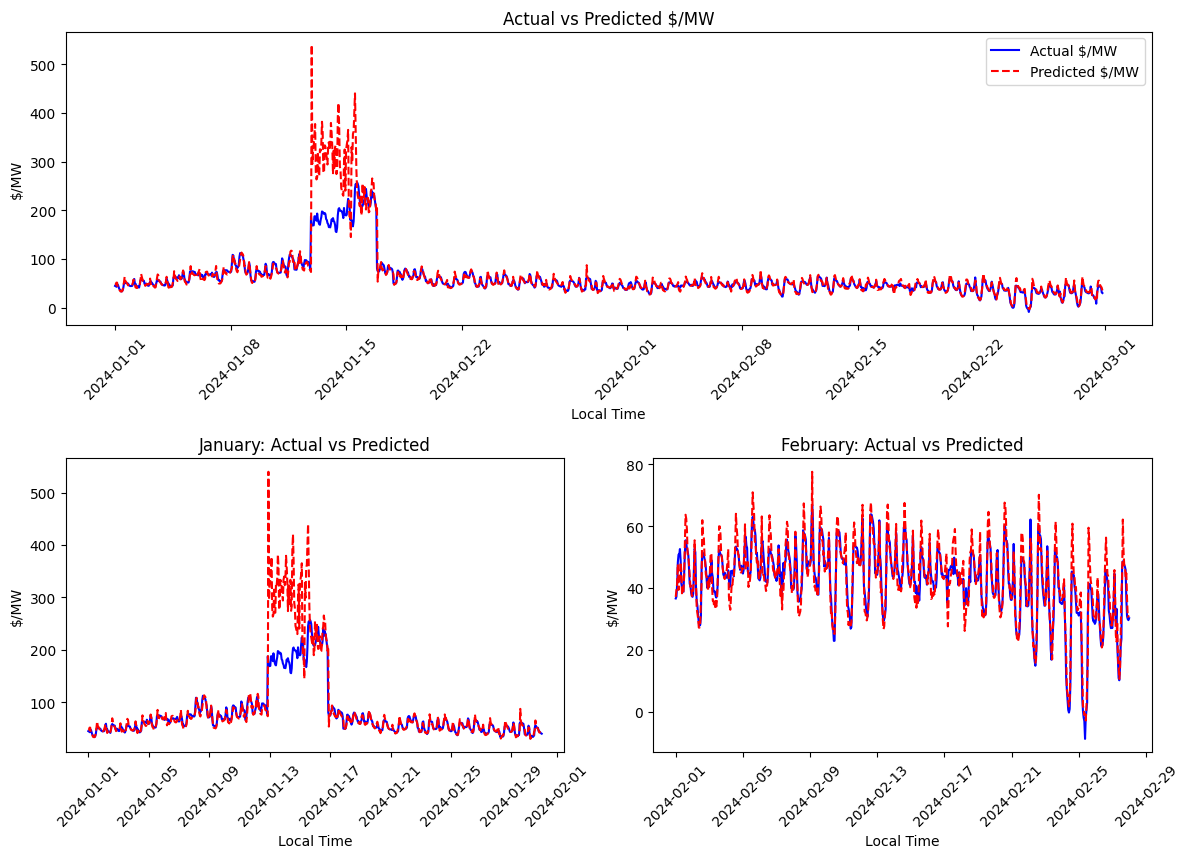

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

test_df_for_plotting = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/Final_test.csv', usecols=['local_time'])
test_local_time = pd.to_datetime(test_df_for_plotting['local_time'])

if len(test_local_time) > len(y_test_pred):
    test_local_time = test_local_time[:len(y_test_pred)]

# Convert 'test_local_time' to datetime if it's not already
test_local_time = pd.to_datetime(test_local_time)

# Filter for January
january_start = "2024-01-01"
january_end = "2024-01-31"
is_january = (test_local_time >= january_start) & (test_local_time <= january_end)
january_times = test_local_time[is_january]
january_actual = y_test[is_january]
january_predictions = y_test_pred[is_january]

# Filter for February
february_start = "2024-02-01"
february_end = "2024-02-28"
is_february = (test_local_time >= february_start) & (test_local_time <= february_end)
february_times = test_local_time[is_february]
february_actual = y_test[is_february]
february_predictions = y_test_pred[is_february]

# Set up the plot layout
plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 2)  # Define a grid of 3 rows and 2 columns

# Main plot spanning the first row
ax0 = plt.subplot(gs[0, :])  # This subplot takes up the first row
ax0.plot(test_local_time, y_test, label='Actual $/MW', color='blue')
ax0.plot(test_local_time, y_test_pred, label='Predicted $/MW', color='red', linestyle='--')
ax0.set_title('Actual vs Predicted $/MW')
ax0.set_xlabel('Local Time')
ax0.set_ylabel('$/MW')
ax0.legend()
ax0.tick_params(axis='x', rotation=45)

# January subplot in the second row, first column
ax1 = plt.subplot(gs[1, 0])  # Bottom left
ax1.plot(january_times, january_actual, label='Actual $/MW', color='blue')
ax1.plot(january_times, january_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax1.set_title('January: Actual vs Predicted')
ax1.set_xlabel('Local Time')
ax1.set_ylabel('$/MW')
ax1.tick_params(axis='x', rotation=45)

# February subplot in the second row, second column
ax2 = plt.subplot(gs[1, 1])  # Bottom right
ax2.plot(february_times, february_actual, label='Actual $/MW', color='blue')
ax2.plot(february_times, february_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax2.set_title('February: Actual vs Predicted')
ax2.set_xlabel('Local Time')
ax2.set_ylabel('$/MW')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()  # Adjust layout to make room for all elements
plt.show()

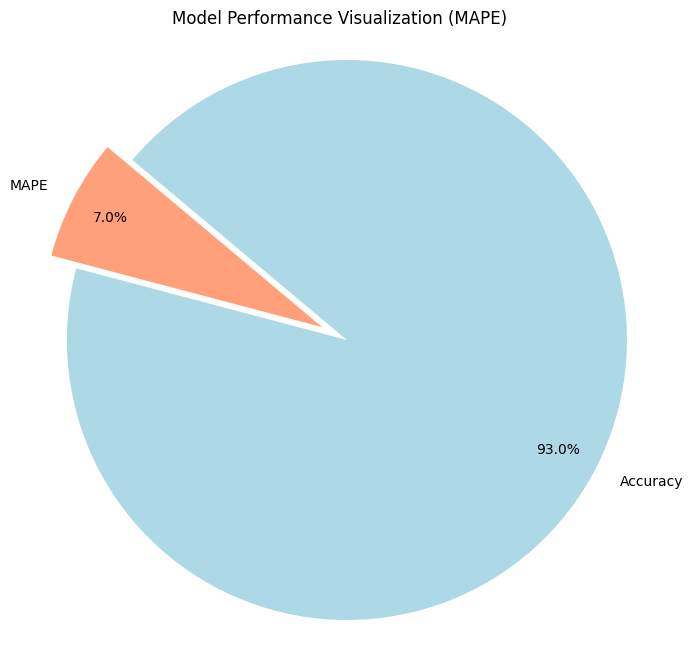

In [ ]:
import matplotlib.pyplot as plt

# Assuming test_metrics is structured as [MAE, MAPE, sMAPE, RMSE]
mape = test_metrics[1]
accuracy = 100 - mape  # Calculating accuracy as the complement of MAPE

# Data for plotting
labels = ['MAPE', 'Accuracy']
sizes = [mape, accuracy]
colors = ['#FFA07A', '#ADD8E6']
explode = (0.1, 0)  # Only explode the MAPE slice

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, pctdistance=0.85)
plt.axis('equal')
plt.title('Model Performance Visualization (MAPE)')
plt.show()


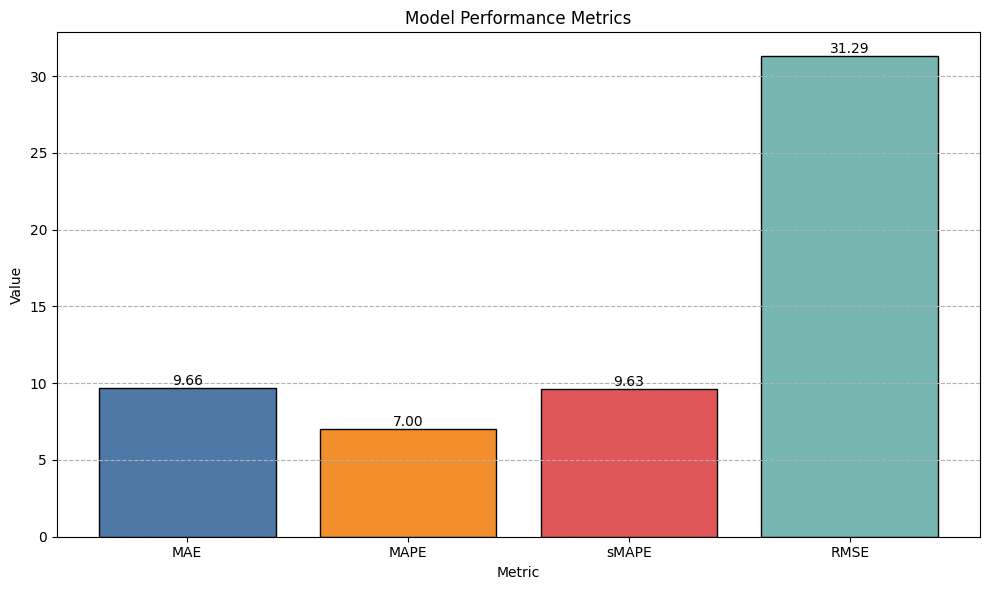

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metrics_names = ['MAE', 'MAPE', 'sMAPE', 'RMSE']
x_pos = np.arange(len(metrics_names))

plt.figure(figsize=(10, 6))
bars = plt.bar(x_pos, test_metrics, color=['#4E79A7', '#F28E2B', '#E15759', '#76B7B2'], edgecolor='black')
plt.xticks(x_pos, metrics_names)

# Adding labels and title
plt.title('Model Performance Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')

# Adding metric values above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
